In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, sem
from theoretical import straddle_option
from utility import *

In [2]:
np.random.seed(4198)

def plain_example():
    n = 100

    # Generate samples
    Z = np.random.normal(size=n)
    X = np.exp(Z)

    # Calculate sample mean and standard error
    X_bar = np.mean(X)
    se = sem(X)
    re = se / np.abs(X_bar)

    return X_bar, se, re

def control_variate_example():
    n = 100

    # Generate samples
    Z = np.random.normal(size=n)
    X = np.exp(Z)
    Y = Z

    mu_Y = 0  # E[Y] for standard normal

    # Calculate covariance and variance
    cov_XY = np.cov(X, Y)[0, 1]
    var_Y = np.var(Y)

    # Optimal b
    b_opt = cov_XY / var_Y

    # Control variate estimator
    H = X - b_opt * (Y - mu_Y)
    H_hat = H.mean()
    se = sem(H)
    re = se / np.abs(H_hat)

    return H_hat, se, re

In [3]:
plain_est, plain_se, plain_re = plain_example()
cv_est, cv_se, cv_re = control_variate_example()

print("N = 100 samples")

print(f"Plain MC Estimate: {plain_est:.4f}, SE: {plain_se:.4f}, RE: {plain_re:.4f}")
print(f"CV Estimate: {cv_est:.4f}, SE: {cv_se:.4f}, RE: {cv_re:.4f}")

N = 100 samples
Plain MC Estimate: 1.8039, SE: 0.1846, RE: 0.1023
CV Estimate: 1.5471, SE: 0.1010, RE: 0.0653


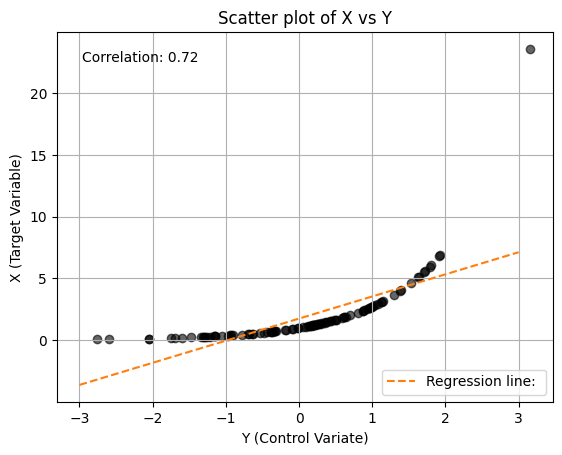

In [4]:
# plot X against Y to visualise correlation
n = 100
Z = np.random.normal(size=n)
X = np.exp(Z)
Y = Z

plt.scatter(Y, X, color='black', alpha=0.6)

# plot the regression line and display the correlation coefficient
m, b = np.polyfit(Y, X, 1)

x = np.linspace(-3, 3, 100)

plt.plot(x, m*x + b, color='tab:orange', label=f'Regression line: ', linestyle='--')
corr = np.corrcoef(Y, X)[0, 1]

plt.legend()
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=plt.gca().transAxes, verticalalignment='top')


plt.title("Scatter plot of X vs Y")
plt.xlabel("Y (Control Variate)")
plt.ylabel("X (Target Variable)")
plt.grid(True)
plt.show()

## Straddle Option
Suppose we want to estimate the price of a straddle option at maturity $T$, where $S_T$ is the stock price at time $T$ and $K$ is the strike price. The stock price $S_t$ is assumed to follow a geometric Brownian motion under the risk-neutral measure
$$ S_t = S_0 \exp\left\{(r - \frac{1}{2} \sigma^2) t + \sigma W_t\right\} $$
where $W_t$ is a standard Brownian motion, $r$ is the risk-free interest rate, and $\sigma$ is the volatility of the stock.
We can use the stock price itself as a control variate since its expected value under the risk-neutral measure is known.

The option price can be written as
$$v = e^{-rT} E[(S_T - K)^+ + (K - S_T)^+]$$
and is estimated with the control variate estimator
$$ \hat{H} = \frac{1}{N} \sum_{i = 1}^{N} e^{-rT} \left[ \bar{X_i} - b(\bar{Y_i} - E[Y]) \right] $$
where $X = (S_T - K)^+ (K - S_T)^+$ and $Y = S_T$.

Assume that $S_0 = 40$, $K = 50$, $r = 0.05$, $\sigma = 0.2$, and $T = 1$. We will compare the plain Monte Carlo estimator with the control variate estimator.

In [5]:
def straddle_option_payoff(S_T, K1, K2):
    return np.maximum(S_T - K1, 0) + np.maximum(K2 - S_T, 0)

def final_stock_price(S_0, r, sig, T, Z):
    return S_0 * np.exp((r - 0.5 * sig**2) * T + sig * np.sqrt(T) * Z)

def straddle_option_example(S_0):
    np.random.seed(4198)

    K, r, T, sig = 50, 0.02, 1.0, 0.2
    n = 10_000

    def plain():
        Z = np.random.normal(size=n)
        S_T = final_stock_price(S_0, r, sig, T, Z)
        
        payoffs = straddle_option_payoff(S_T, K, K)
        discounted_payoff = np.exp(-r * T) * payoffs
        
        est = np.mean(discounted_payoff)
        se = sem(discounted_payoff)
        re = se / np.abs(est)

        return est, se, re

    def control_variate():
        Z = np.random.normal(size=n)
        S_T = final_stock_price(S_0, r, sig, T, Z)
        
        payoffs = straddle_option_payoff(S_T, K, K)
        discounted_payoff = np.exp(-r * T) * payoffs
        
        # Control variate: Underlying stock price at maturity
        Y = S_T
        mu_Y = S_0 * np.exp(r * T)  # E[S_T] under risk-neutral measure

        b_opt = control_variate_coeffient(discounted_payoff, Y)
        
        H = discounted_payoff - b_opt * (Y - mu_Y)

        H_hat = np.mean(H)
        se = sem(H)
        re = se / np.abs(H_hat)

        return H_hat, se, re

    plain_est, plain_se, plain_re = plain()
    cv_est, cv_se, cv_re = control_variate()

    print("Straddle Option Pricing with N =", n)
    print(f"Plain MC Estimate: {plain_est:.4f}, SE: {plain_se:.4f}, RE: {plain_re:.4f}")
    print(f"CV Estimate:       {cv_est:.4f}, SE: {cv_se:.4f}, RE: {cv_re:.4f}")

    var_reduction = (plain_se**2 - cv_se**2) / plain_se**2 * 100
    print(f"\nVariance Reduction: {var_reduction:.2f}%")
    print()


In [6]:
straddle_option_example(40)
straddle_option_example(50)
straddle_option_example(60)

Straddle Option Pricing with N = 10000
Plain MC Estimate: 10.3312, SE: 0.0614, RE: 0.0059
CV Estimate:       10.4381, SE: 0.0400, RE: 0.0038

Variance Reduction: 57.54%

Straddle Option Pricing with N = 10000
Plain MC Estimate: 7.8795, SE: 0.0628, RE: 0.0080
CV Estimate:       7.8737, SE: 0.0593, RE: 0.0075

Variance Reduction: 10.89%

Straddle Option Pricing with N = 10000
Plain MC Estimate: 12.7905, SE: 0.1018, RE: 0.0080
CV Estimate:       12.7598, SE: 0.0416, RE: 0.0033

Variance Reduction: 83.34%



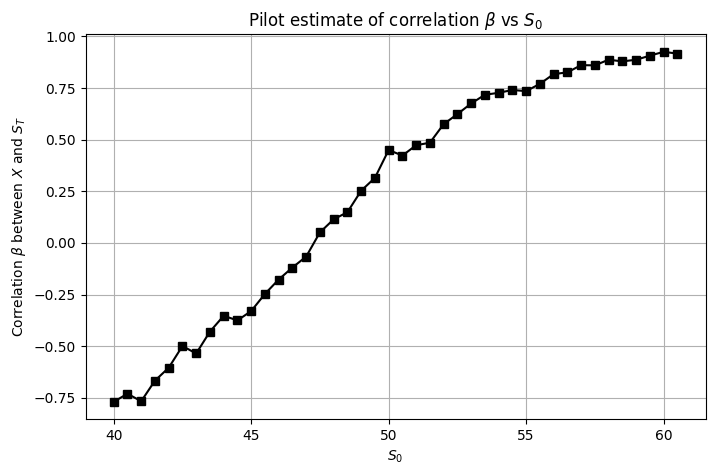

In [7]:
np.random.seed(4198)

# Parameters
S0_values = np.arange(40, 61, 0.5)
r, sig, K, T = 0.02, 0.2, 50, 1
N_pilot = 2000  # pilot sample size

beta_list = []

for S_0 in S0_values:
    # Generate pilot sample
    Z = np.random.normal(0, 1, N_pilot)
    S_t = final_stock_price(S_0, r, sig, T, Z)
    X = np.maximum(S_t - K, 0) + np.maximum(K - S_t, 0)  # |S_T - K|
    Y = S_t

    # Correlation
    beta = np.corrcoef(X, Y)[0, 1]
    beta_list.append(beta)

# Convert to numpy array for plotting
beta_array = np.array(beta_list)

# Plot beta vs S_0
plt.figure(figsize=(8,5))
plt.plot(S0_values, beta_array, color='black', marker='s')

plt.xlabel('$S_0$')
plt.ylabel('Correlation $\\beta$ between $X$ and $S_T$')

plt.title('Pilot estimate of correlation $\\beta$ vs $S_0$')

plt.grid()

plt.show()

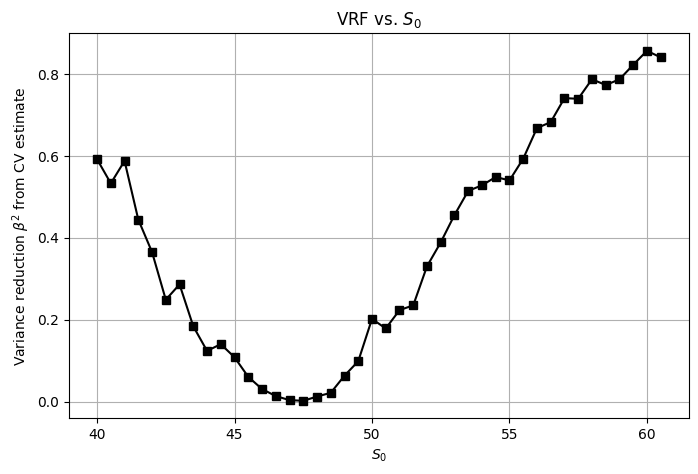

In [8]:
vrf = beta_array**2

# Plot vrf vs S_0
plt.figure(figsize=(8,5))
plt.plot(S0_values, vrf, color='black', marker='s')

plt.xlabel('$S_0$')
plt.ylabel('Variance reduction $\\beta^2$ from CV estimate')

plt.title('VRF vs. $S_0$')

plt.grid()

plt.show()

In [9]:
def visualize_straddle_control_variate(S_0):
    np.random.seed(4198)
    
    K, r, T, sig = 50, 0.02, 1.0, 0.2
    N = 10_000

    Z = np.random.normal(0, 1, N)
    S_T = final_stock_price(S_0, r, sig, T, Z)
    
    X = straddle_option_payoff(S_T, K, K) * np.exp(-r * T)
    
    Y = S_T
    
    plt.scatter(Y, X, color='black', alpha=0.5)

    m, b = np.polyfit(Y, X, 1)
    x = np.linspace(min(Y), max(Y), 100)
    plt.plot(x, m*x + b, color='tab:orange', label=f'Regression line (slope={m:.2f})', linestyle='--')
    
    corr = np.corrcoef(Y, X)[0, 1]
    plt.legend()
    plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

    plt.title("Scatter plot of Straddle Payoff vs Stock Price at Maturity")
    plt.xlabel("$Y = S_T$ (Control Variate)")
    plt.ylabel("$X$ = Discounted Straddle Payoff (Target Variable)")
    plt.grid(True)
    plt.show()

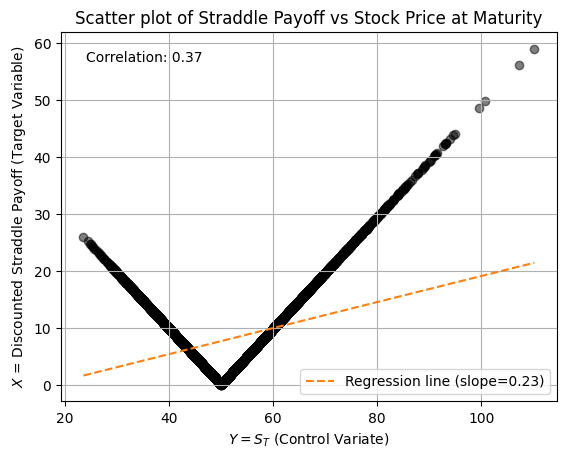

In [10]:
visualize_straddle_control_variate(50)

Aha! The correlation is quite weak, which explains why the control variate method did not perform well in this case. For the control variate method to be effective, we need a strong correlation between $X$ and $Y$.

### Designing An Effective Control Variate
Constructing control variates require knowledge of the expected value of the control variate. In practice, this can be challenging. One strategy is to use a linear combination of multiple control variates whose expectations are known. For the straddle option, we could consider using both $S_T$ and $S_T^2$ as control variates, since their expectations can be derived from the properties of the geometric Brownian motion.

Since $S_T$ is log-normally distributed, with mean and variance
$$E[S_T] = S_0 e^{rT}, \quad \text{Var}(S_T) = S_0^2 e^{2rT}(e^{\sigma^2 T} - 1), $$
we can also compute
$$E[S_T^2] = Var(S_T) + E[S_T]^2 = S_0^2 e^{2rT} e^{\sigma^2 T}.$$
Then we can fit a linear regression model to find the optimal coefficients $b_1$, $b_2$ for the control variates.

The estimator becomes
$$ \hat{H} = \bar{X} - b_1(\bar{Y_1} - E[Y_1]) - b_2(\bar{Y_2} - E[Y_2]) $$
where $Y_1 = S_T$ and $Y_2 = S_T^2$.

In [11]:
# Regress X ~ Y1 + Y2 and plot to visualize the correlation
def visualize_straddle_control_variate_2():
    S_0 = 47
    K = 50
    r = 0.02
    sigma = 0.2
    T = 1.0

    num_samples = 10_000
    Z = np.random.normal(0, 1, num_samples)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    X = straddle_option_payoff(S_T, K, K) * np.exp(-r * T)

    # Fit regression X ~ Y1 + Y2
    A = np.vstack([S_T, S_T**2, np.ones(len(S_T))]).T
    coeffs, _, _, _ = np.linalg.lstsq(A, X, rcond=None)
    
    # Predicted values from regression
    X_pred = A @ coeffs

    plt.scatter(S_T, X, color='black', alpha=0.5)
    m, b = np.polyfit(X_pred, X, 1)
    x = np.linspace(min(S_T), max(S_T), 100)

    A_new = np.vstack([x, x**2, np.ones(len(x))]).T

    plt.plot(x, A_new @ coeffs , color='tab:orange', label=f'Regression Quadratic', linestyle='--')
    corr = np.corrcoef(X_pred, X)[0, 1]

    plt.legend()
    plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
    
    plt.title("Scatter plot of Straddle Payoff vs $S_T$")
    plt.xlabel("$Y = S_T$ (Control Variate)")
    plt.ylabel("X = Discounted Straddle Payoff (Target Variable)")

    plt.grid(True)
    
    plt.show()

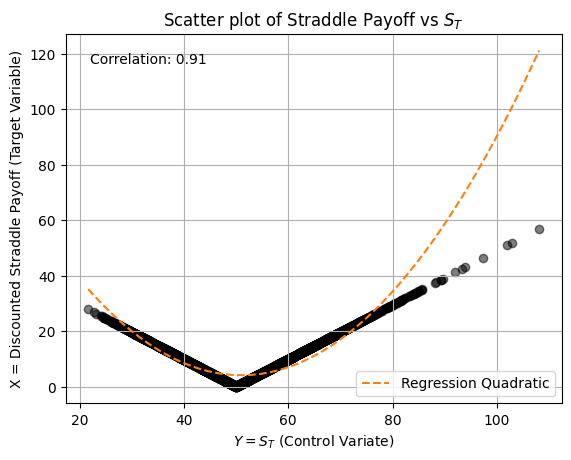

In [12]:
visualize_straddle_control_variate_2()

In [13]:
def straddle_option_example_2(num_samples=10_000):
    S_0 = 47 # chosen to minimize the variance reduction
    K = 50
    r = 0.02
    sigma = 0.2
    T = 1.0

    def plain():
        Z = np.random.normal(0, 1, num_samples)
        S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        
        payoffs = straddle_option_payoff(S_T, K, K)
        discounted_payoff = np.exp(-r * T) * payoffs
        
        est = np.mean(discounted_payoff)
        se = sem(discounted_payoff)
        re = se / np.abs(est)

        return est, se, re
    
    def control_variate():
        Z = np.random.normal(0, 1, num_samples)
        S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        
        payoffs = straddle_option_payoff(S_T, K, K)
        discounted_payoff = np.exp(-r * T) * payoffs
        
        # Control variate: Underlying stock price at maturity
        Y = S_T
        mu_Y = S_0 * np.exp(r * T)  # E[S_T] under risk-neutral measure

        cov_XY = np.cov(discounted_payoff, Y)[0, 1]
        var_Y = np.var(Y)

        b_opt = cov_XY / var_Y
        
        H = discounted_payoff - b_opt * (Y - mu_Y)

        H_hat = np.mean(H)
        se = sem(H)
        re = se / np.abs(H_hat)

        return H_hat, se, re
    
    def better_control_variate():
        Z = np.random.normal(0, 1, num_samples)
        S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        
        payoffs = straddle_option_payoff(S_T, K, K)
        discounted_payoff = np.exp(-r * T) * payoffs
        
        # Better Control variate: S_T and S_T^2
        Y1 = S_T
        Y2 = S_T**2
        mu_Y1 = S_0 * np.exp(r * T)
        mu_Y2 = S_0**2 * np.exp(2 * r * T + sigma**2 * T)

        # Fit coefficients b1 and b2 using regression X ~ Y1 + Y2
        A = np.vstack([Y1, Y2, np.ones(num_samples)]).T
        b_opt, _, _, _ = np.linalg.lstsq(A, discounted_payoff, rcond=None)
        b1_opt, b2_opt = b_opt[0], b_opt[1]
    
        H = discounted_payoff - b1_opt * (Y1 - mu_Y1) - b2_opt * (Y2 - mu_Y2)
        
        H_hat = np.mean(H)
        se = sem(H)
        re = se / np.abs(H_hat)

        return H_hat, se, re
    
    plain_est, plain_se, plain_re = plain()
    cv_est, cv_se, cv_re = control_variate()
    bcv_est, bcv_se, bcv_re = better_control_variate()

    print("Straddle Option Pricing with N =", num_samples)
    print(f"Plain MC Estimate: {plain_est:.4f}, SE: {plain_se:.4f}, RE: {plain_re:.4f}")
    print(f"Control Variate Estimate: {cv_est:.4f}, SE: {cv_se:.4f}, RE: {cv_re:.4f}")
    print(f"Better Control Variate Estimate: {bcv_est:.4f}, SE: {bcv_se:.4f}, RE: {bcv_re:.4f}")

    var_reduction = (plain_se**2 - cv_se**2) / plain_se**2 * 100
    better_var_reduction = (plain_se**2 - bcv_se**2) / plain_se**2 * 100
    print(f"\nVariance Reduction (1 CV): {var_reduction:.2f}%")
    print(f"Variance Reduction (2 CVs): {better_var_reduction:.2f}%")
    

In [14]:
straddle_option_example_2()

Straddle Option Pricing with N = 10000
Plain MC Estimate: 7.8200, SE: 0.0566, RE: 0.0072
Control Variate Estimate: 7.7715, SE: 0.0563, RE: 0.0072
Better Control Variate Estimate: 7.7982, SE: 0.0218, RE: 0.0028

Variance Reduction (1 CV): 1.16%
Variance Reduction (2 CVs): 85.18%


### Enhancing Variance Reduction with Multiple Control Variates

Compared to the earlier control variate estimator that used only $Y$, the new estimator—which incorporates both $Y$ and $Y^2$—achieves a much greater reduction in variance. This improvement comes from the stronger correlation between the target variable $X$ and the predictions produced by the linear regression model. In other words, by expanding our set of control variates, we can capture more of the variation in $X$ that is driven by $Y$.

In principle, we could continue adding higher-order moments of $Y$ (such as $Y^3$, $Y^4$, and so on) to further reduce variance. However, this approach quickly runs into a practical limitation: we need to know the expected values $E[Y^k]$ for each additional term, and these may not always have simple or closed-form expressions. Without these expectations, the control variate method cannot be applied directly.

There’s also a trade-off to consider. Each new term we add to the regression increases the computational cost of fitting the model. Beyond a certain point, the marginal gain in variance reduction may not justify this added complexity.

Still, the key insight here is powerful: we can achieve significant variance reduction by constructing a **linear combination of control variates** derived from a related random variable $Y$. This suggests a more general strategy—rather than adding arbitrary powers of $Y$, we can search for a **feature space**

$$
\Phi(Y) = \{\psi_1(Y), \psi_2(Y), \ldots\},
$$

where the expectations $E[\psi_i(Y)]$ are tractable and $\Phi(Y)$ can approximate $X$ well.